<a href="https://colab.research.google.com/github/dipnarayan501/Assignment3/blob/main/attention_without_wandb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from tensorflow import keras
import tensorflow as tf
from keras.layers import SimpleRNN,LSTM,GRU,Embedding,Dense,Dropout,Input,Concatenate
from keras import Model

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
#path to the dataset
zip_path = "drive/MyDrive/hi.zip"
!cp "{zip_path}" .
!unzip -q hi.zip

In [5]:
#Retrieving dataset
def load_data(path):
    with open(path) as fil:
        data = pd.read_csv(fil,sep='\t',header=None,names=["hi","en",""],skip_blank_lines=True,index_col=None)
    data = data[data['hi'].notna()]
    data = data[data['en'].notna()]
    data = data[['hi','en']]
    return data

In [6]:
#Getteing data
train = load_data("hi/lexicons/hi.translit.sampled.train.tsv")
dev = load_data("hi/lexicons/hi.translit.sampled.dev.tsv")
test = load_data("hi/lexicons/hi.translit.sampled.test.tsv")

In [7]:
x = train['en'].values
y = train['hi'].values
y = '\t'+y+'\n'

In [8]:
train.head()

,hi,en
0,अं,an
1,अंकगणित,ankganit
2,अंकल,uncle
3,अंकुर,ankur
4,अंकुरण,ankuran


In [9]:
#Getting unique tokens
def unique_tokenize(train):
    en = train['en'].values
    hi = train['hi'].values
    hi = '\t'+hi+'\n'
    english_tokens = set()
    hindi_tokens = set()
    
    for x,y in zip(en,hi):
        for ch in x:
            english_tokens.add(ch)
        for ch in y:
            hindi_tokens.add(ch)
    english_tokens = sorted(list(english_tokens))
    hindi_tokens = sorted(list(hindi_tokens))
    return hindi_tokens , english_tokens
hindi_tokens , english_tokens = unique_tokenize(train)

In [10]:
#Mapping tokens
def tokenize_map(hindi_tokens , english_tokens):
    eng_token_map = dict([(ch,i+1) for i,ch in enumerate(english_tokens)])
    hin_token_map = dict([(ch,i+1) for i,ch in enumerate(hindi_tokens)])
    hin_token_map[" "] = 0
    eng_token_map[" "] = 0
    return hin_token_map, eng_token_map

hin_token_map, eng_token_map = tokenize_map(hindi_tokens , english_tokens)

In [11]:
#Getting maximum tokens length
max_eng_len = max([len(i) for i in x])
max_hin_len = max([len(i) for i in y])

In [12]:
np.random.seed(42)
reverse_eng_map = dict([(i,char) for char,i in eng_token_map.items()])
reverse_hin_map = dict([(i,char) for char,i in hin_token_map.items()])

In [13]:
#Preprocessing data
def process(data):
    x,y = data['en'].values, data['hi'].values
    y = "\t" + y + "\n"
    
    a = np.zeros((len(x),max_eng_len),dtype="float32")
    b = np.zeros((len(y),max_hin_len),dtype="float32")
    c = np.zeros((len(y),max_hin_len,len(hindi_tokens)+1),dtype="int")
    
    
    for i,(xx,yy) in enumerate(zip(x,y)):
        for j,ch in enumerate(xx):
            a[i,j] = eng_token_map[ch]

        a[i,j+1:] = eng_token_map[" "]
        for j,ch in enumerate(yy):
            b[i,j] = hin_token_map[ch]

            if j>0:
                c[i,j-1,hin_token_map[ch]] = 1

        b[i,j+1:] = hin_token_map[" "]
        c[i,j:,hin_token_map[" "]] = 1
        
    return a,b,c

In [14]:

#Getting preprocess train val and test dataset
trainx, trainxx, trainy = process(train)
valx, valxx, valy = process(dev)
testx,testxx,testy = process(test)

In [15]:
#reverse mapping
np.random.seed(42)
reverse_eng_map = dict([(i,char) for char,i in eng_token_map.items()])
reverse_hin_map = dict([(i,char) for char,i in hin_token_map.items()])

In [16]:
#Attention code here
class Attention(tf.keras.layers.Layer):
    def __init__(self, units,name=None, **kwargs):
        super(Attention, self).__init__(name=name)
        self.W1 = Dense(units,name='w1')
        self.W2 = Dense(units,name='w2')
        self.V = Dense(1,name='v')
        self.units = units
        super(Attention, self).__init__(**kwargs)

    def call(self, tup):
        # query hidden state 
        # query_with_time_axis 
        # values 
        # we are doing this to broadcast addition along the time axis to calculate the score
        query = tup[0]
        values = tup[1]
        query_with_time_axis = tf.expand_dims(query, 1)
        #Getting scores
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights 
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector 
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights
    
        
    def get_config(self):
        config = super(Attention,self).get_config()
        config.update({
            'units': self.units
        })
        return config

In [17]:
#Generate encoder and decoders
def build_model(cell = "LSTM",units = 32, enc_layers = 1, dec_layers = 1,embed_dim = 32,dense_size=256,dropout=None):
    keras.backend.clear_session()
    encoder_inputs = Input(shape=(None,),name='input1')
    encoder_embedding = Embedding(input_dim=len(english_tokens)+1,output_dim = embed_dim,mask_zero=True,name="enc_embed")
    encoder_context = encoder_embedding(encoder_inputs)
    decoder_inputs = Input(shape=(None,),name='input2')
    decoder_embedding = Embedding(input_dim = len(hindi_tokens)+1,output_dim = embed_dim,mask_zero=True,name="dec_embed")
    decoder_context = decoder_embedding(decoder_inputs)
    attention = Attention(units,name='attention')
    tot_out = []
    concat1 = Concatenate(axis=-1,name='concat1')
    concat2 = Concatenate(axis=1,name='concat2')    
    if cell == "LSTM":
        encoder_prev = [LSTM(units,return_sequences=True,name=f"enc_{i}") for i in range(enc_layers-1)]
        encoder_fin = LSTM(units,return_sequences=True,return_state=True,name=f"enc_{enc_layers-1}")
        temp = encoder_context
        for x,lay in enumerate(encoder_prev):
            temp = lay(temp)
            if dropout is not None:
                temp = Dropout(dropout,name=f'do_{x}')(temp)
            
        enc_out = encoder_fin(temp)
        dec_states = enc_out[1:]
        
        decoder = [LSTM(units,return_sequences=True,return_state=True,name=f"dec_{i}") for i in range(dec_layers)]
        temp_states = [dec_states]*dec_layers
        
        for i in range(max_hin_len):
            tup = (temp_states[0][0],enc_out[0])
            context,att_wts = attention(tup)
            temp = concat1([tf.expand_dims(context, 1), decoder_context[:,i:i+1,:]])

            for i in range(dec_layers):
                temp,sh,sc = decoder[i](temp,initial_state=temp_states[i])
                temp_states[i] = [sh,sc]
            tot_out.append(temp)
            
        outt = concat2(tot_out)
       
    elif cell == "GRU":
        encoder_prev = [GRU(units,return_sequences=True,name=f"enc_{i}") for i in range(enc_layers-1)]
        encoder_fin = GRU(units,return_sequences=True,return_state=True,name=f"enc_{enc_layers-1}")
        temp = encoder_context
        for x,lay in enumerate(encoder_prev):
            temp = lay(temp)
            if dropout is not None:
                temp = Dropout(dropout,name=f'do_{x}')(temp)
            
        enc_out = encoder_fin(temp)
        dec_states = enc_out[1:]
        
        decoder = [GRU(units,return_sequences=True,return_state=True,name=f"dec_{i}") for i in range(dec_layers)]
        temp_states = []
        for _ in range(dec_layers):
            temp_states += dec_states
        
        for i in range(max_hin_len):
            tup = (temp_states[0],enc_out[0])
            context,att_wts = attention(tup)
            temp = concat1([tf.expand_dims(context, 1), decoder_context[:,i:i+1,:]])

            for i in range(dec_layers):
                temp,st = decoder[i](temp,initial_state=temp_states[i])
                temp_states[i] = st
            tot_out.append(temp)
            
        outt = concat2(tot_out)
            
        
    dense_lay1 = Dense(dense_size,activation='relu',name='dense1')
    pre_out = dense_lay1(outt)
    dense_lay2 = Dense(len(hindi_tokens)+1,activation = 'softmax',name='dense2')
    final_output = dense_lay2(pre_out)
    
    train = Model([encoder_inputs,decoder_inputs],final_output)
    
    return train


In [ ]:
#Finding word level accuracy by substituting best parameters

train = build_model(units=256,
                    dense_size=128,
                    enc_layers=1,
                    dec_layers=1,
                    cell = "GRU",
                    dropout = 0.2,
                    embed_dim = 256)
train.compile(optimizer = 'adam',loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint= tf.keras.callbacks.ModelCheckpoint('best_model_attention.h5',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
train.fit([trainx,trainxx],trainy,
             batch_size=64,
             validation_data = ([valx,valxx],valy),
             epochs=5,
             callbacks=[checkpoint])

In [20]:
keras.backend.clear_session()
#Loading model
model = keras.models.load_model('best_model_attention.h5',custom_objects={'accuracy':'accuracy','Attention':Attention})

In [21]:
#Defining inference model
def inference_models(model,nunits=32,enc_layers=1,dec_layers=1,cell='LSTM',dropout=None):
    keras.backend.clear_session()
    encoder_inputs = model.input[0]
    encoder_embedding = model.get_layer('enc_embed')
    encoder_context = encoder_embedding(encoder_inputs)
    decoder_inputs = model.input[1]
    decoder_embedding = model.get_layer('dec_embed')
    decoder_context = decoder_embedding(decoder_inputs)
    
    
    encoder_prev = [model.get_layer(f'enc_{i}') for i in range(enc_layers-1)]
    encoder_fin = model.get_layer(f'enc_{enc_layers-1}')
    temp = encoder_context
    for i,lay in enumerate(encoder_prev):
        temp = lay(temp)
        if dropout is not None:
            temp = model.get_layer(f'do_{i}')(temp)
     
    if cell == "LSTM":
        enc_out, state_h,state_c = encoder_fin(temp)
        enc_final = [enc_out,state_h,state_c]
        
    elif cell == "GRU":
        enc_out, state = encoder_fin(temp)
        enc_final = [enc_out,state]

    encoder_model = keras.models.Model(encoder_inputs,enc_final)
    
    
    decoder = [model.get_layer(f'dec_{i}') for i in range(dec_layers)]
    
    attention = model.get_layer('attention')
    
    concat1 = model.get_layer('concat1')

    if cell == "LSTM":
        state_inputs = []
        state_outputs = []
        
        encout_input = Input(shape=(None,nunits),name='inputenc')
        
        temp = decoder_context[:,-1:,:]
                                                                  
        for i in range(dec_layers):
            decoder_input_h = Input(shape=(nunits,),name=f"inputh{i}")
            decoder_input_c = Input(shape=(nunits,),name=f"inputc{i}")
            
            if i==0:
                tup = (decoder_input_h,encout_input)
                context,att_wts_out = attention(tup)
                temp = concat1([tf.expand_dims(context, 1), temp])
                
            temp,sh,sc = decoder[i](temp,initial_state = [decoder_input_h,decoder_input_c])
            state_inputs += [decoder_input_h,decoder_input_c]
            state_outputs += [sh,sc]
            
        decoder_input_pass = [decoder_inputs,encout_input] + state_inputs

    elif cell == "GRU":
        state_inputs = []
        state_outputs = []
        
        encout_input = Input(shape=(None,nunits),name='inputenc')
        
        temp = decoder_context[:,:1,:]
                                                                  
        for i in range(dec_layers):
            state_input = Input(shape=(nunits,),name=f"inputs{i}")
            
            if i==0:
                tup = (state_input,encout_input)
                context,att_wts_out = attention(tup)
                temp = concat1([tf.expand_dims(context, 1), temp])
                
            temp,s = decoder[i](temp,initial_state = state_input)
            state_inputs.append(state_input)
            state_outputs.append(s)
            
        decoder_input_pass = [decoder_inputs,encout_input] + state_inputs

    pre_out = model.get_layer('dense1')(temp)
    final_output = model.get_layer('dense2')(pre_out)

    decoder_model = keras.models.Model(decoder_input_pass, [final_output,att_wts_out]+state_outputs)
    
    return encoder_model,decoder_model

In [22]:
#Initialising encoder and decoder model layer
enc,dec = inference_models(train,nunits=256,enc_layers=1,dec_layers=1,cell="GRU",dropout='yes')

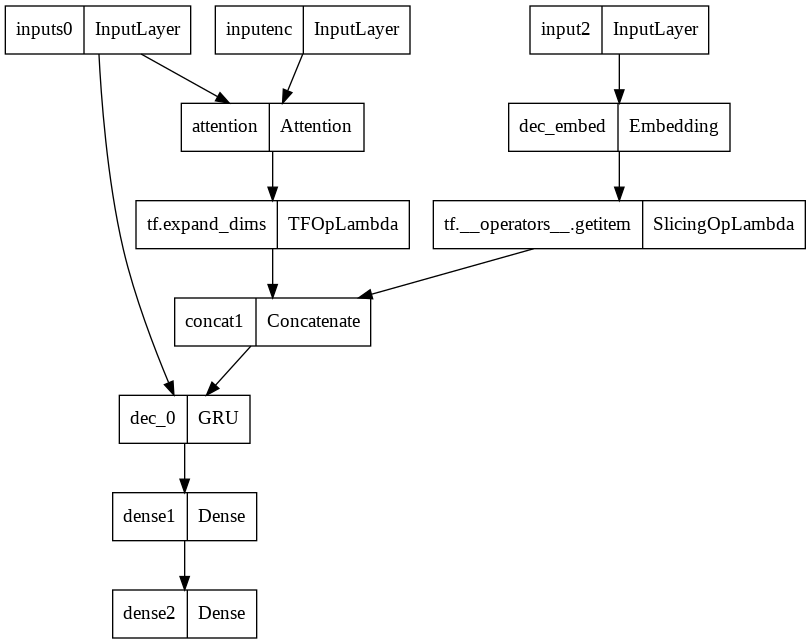

In [55]:
#plot decode model
keras.utils.plot_model(dec)

In [24]:
#Beam search code here
#It returns output word and attention weights
def beam_search(inp,k,dec_layers,cell="LSTM"):
    enc_out = enc.predict(inp)
    statess = enc_out[1:]
    target_seq = np.zeros((inp.shape[0],1))
    target_seq[:,0] = hin_token_map["\t"]
    if cell == "LSTM":
        states = []
        for i in range(dec_layers):
            states += [statess[0],statess[1]]
    else:
        states = []
        for i in range(dec_layers):
            states += [statess]
            
    output = dec.predict([target_seq,enc_out[0]]+states)
    states = output[2:]
    
    stat1 = np.asarray(states).transpose([1,0,2])
    
    best_chars = np.argsort(output[0][:,-1,:],axis=-1)[:,-k:]
    scores = np.sort(output[0][:,-1,:],axis=-1)[:,-k:]
    sequences = [[([ch],-np.log(sc),stat1[i],0,output[1][i]) for ch,sc in zip(best_chars[i],scores[i])] for i in range(inp.shape[0])]
    
    for t1 in range(max_hin_len-1):
        candidates = [[] for _ in range(inp.shape[0])]
        for j in range(k):
            target_seq[:,0] = [sequences[i][j][0][-1] for i in range(inp.shape[0])]
            states = list(np.asarray([sequences[i][j][2] for i in range(inp.shape[0])]).transpose([1,0,2]))
            output = dec.predict([target_seq,enc_out[0]]+states,batch_size=32)
            best_chars = np.argsort(output[0][:,-1,:],axis=-1)[:,-k:]
            scores = np.sort(output[0][:,-1,:],axis=-1)[:,-k:]
            
            stat1 = np.asarray(output[2:]).transpose([1,0,2])
            
            for i in range(inp.shape[0]):
                chk = 1 if (sequences[i][j][3]==1 or sequences[i][j][0][-1] == hin_token_map["\n"]) else 0
                if chk == 0:
                    candidates[i] += [(sequences[i][j][0]+[best_chars[i,rep]],
                                       sequences[i][j][1]-np.log(scores[i,rep]),
                                       stat1[i],
                                       chk,
                                       np.concatenate((sequences[i][j][4],output[1][i]),axis=1))
                                      for rep in range(k)]
                else:
                    candidates[i] += [sequences[i][j]]
                    
        for i in range(inp.shape[0]):
            candidates[i] = sorted(candidates[i],key = lambda tup:tup[1]/len(tup[0]))
            sequences[i] = candidates[i][:k]
            

            
        
    res = [list() for i in range(inp.shape[0])]
    att_wts = [list() for i in range(inp.shape[0])]
    for i in range(inp.shape[0]):
        for j in range(k):
            res[i].append(sequences[i][j][0])
            att_wts[i].append(sequences[i][j][4])
        
    return res,att_wts

In [25]:
import time
#It might take a while
#Predicting given test words using beam serach
prediction,att_wts = beam_search(testx,5,1,cell="GRU")


In [26]:
#Test accuracy with beam search
def test_accuracy_beam(prediction):
  acc = 0

  for i,pre in enumerate(prediction):
      chk = 0
      
      for pr in pre:
          fl = 1
          for j,ch in enumerate(pr):
              if ch!=np.argmax(testy[i,j,:]):
                  fl=0
                  break
              if ch==hin_token_map["\n"]:
                  break
          chk = chk or fl
          
      if chk==1:
          acc+=1
          
          
  return (acc/len(prediction))*100



In [27]:
words_beam = []
words = []
#Getting test accuracy using first word of beam search
def test_accuracy(prediction):
  acc = 0

  for i,pre in enumerate(prediction):
      word = []
      word1 = []
      
      orig = ""
      for ch in testx[i]:
          if reverse_eng_map[ch] == " ":
              break
          orig += reverse_eng_map[ch]
      word.append(orig)
      word1.append(orig)
      
      hind = ""
      for ch in testxx[i,1:]:
          if reverse_hin_map[ch] == "\n":
              break
          hind += reverse_hin_map[ch]
      
      word.append(hind)
      word1.append(hind)
      
      fl=0
      
      for j,pr in enumerate(pre):
          deco1 = ""
          for ch in pr:
              if reverse_hin_map[ch] == "\n":
                  break
              deco1 += reverse_hin_map[ch]
          word.append(deco1)
          if j==0:
              word1.append(deco1)
              
          
              if hind==deco1:
                  fl=1
              
      if fl==1:
          acc += 1
          
      words.append(word1)
      words_beam.append(word)
      
  return (acc/len(words))*100



In [ ]:
print("Test accuracy with beam search taking top 5 words is ", test_accuracy_beam(prediction))
print("Test accuracy is taking first words", test_accuracy(prediction))

In [29]:
beam_df = pd.DataFrame(words_beam ,columns=['English','Hindi']+[f'Pred_Attention_{i}' for i in range(5)])
test_df = pd.DataFrame(words,columns=['English','Hindi','pred_Attention'])
test_df.to_csv('predictions_attention.csv')


In [ ]:
test_df.head(5)

## Question 5(d)

In [34]:
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker


mpl.rcParams['font.sans-serif'] = ["Arial Unicode MS"]


#Plotting attention code here
def plot_attention_heatmap(attention, actual, predicted,orig,hind,deco):
    
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(1, 1, 1)
    plott = ax.matshow(attention, cmap='viridis')

    #fontdict = {'fontsize': 16}
    h_font = FontProperties(fname = 'VesperLibre-Regular.ttf') #Upload VesperLibre-Regular.ttf
    
    ax.set_xticklabels([''] + actual, fontdict= {'fontsize': 16}, rotation=90)
    ax.set_yticklabels([''] + predicted, fontproperties=h_font, fontdict={'fontsize': 16})

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    title = f"Original word in english: {orig}\nOriginal word in hindi: {hind}\nDecoded word in hindi: {deco}"
    
    fontdict = {'fontsize': 17}
    plt.title(title,fontproperties=h_font, fontsize=14,y=-.3)
    
    divider = make_axes_locatable(ax)
    c = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(plott,cax=c)
    
    plt.tight_layout()
    plt.savefig(f'{orig}.png', bbox_inches = 'tight')
    plt.show()

In [ ]:
words = beam_df.values
#Upload VesperLibre-Regular.ttf before  running
#Printing heatmap for 10 words taking first predicted word
for _ in range(9):
    sp = np.random.choice(words.shape[0])

    decoded_list = [x for x in words[sp][2].strip()] + ['<end>']
    input_list = [x for x in words[sp][0].strip()] + ['<end>']

    attention_plot = att_wts[sp][0][:len(input_list),:len(decoded_list)].T

    print("Original word in english:", words[sp][0])
    print("Original word in hindi:", words[sp][1])
    print("Decoded word in hindi:", words[sp][2])

    plot_attention_heatmap(attention_plot, input_list, decoded_list,words[sp][0],words[sp][1],words[sp][2])

In [36]:
from IPython.display import HTML as html_print
from IPython.display import display

# get html element
def cstr(s, color='black'):
    if s == ' ':
        return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
    else:
        return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)

# print html
def print_color(t,ch):
    display(html_print(''.join([cstr(ch,color='#fffff')]+[cstr(' ',color='#fffff') for _ in range(3)]+[cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
    colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
     '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
        '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
       '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
    value = max(0,min(int((value * 100) / 5),19))
    return colors[value]

def sigmoid(x):
    z = 1/(1 + np.exp(-x)) 
    return z

def visualize(output, results,dec_char,dec):
    text_colours = []
    for i in range(len(output)):
        text = (results[i], get_clr(output[i]))
        text_colours.append(text)
    print_color(text_colours,dec)

In [40]:
#Visualising word code here
def visualise_connectivity(ex,sp):
    word = words[ex][sp+2]
    engword = words[ex][0]
    attwts = att_wts[ex][sp][:len(engword),:]
    print("Original word in english:",engword)
    print("Decoded word in hindi:",word)
    for i in range(len(word)):
        visualize(attwts[:,i],engword,i,word[i])

#visualise random word
visualise_connectivity(np.random.choice(len(words)),0)    #Rerun 

Original word in english: chaupal
Decoded word in hindi: चौपाल


Gif part

In [ ]:
#download Lohit-devanagri .ttf 
!gdown --id 1g2bTbYAVLmc_IuKzTKOVqgLU7uvUE7dr 

In [52]:
import warnings
from moviepy.editor import ImageSequenceClip
import cv2 as cv

#Generating gif images for single word

def visualise(word_index):

  choosen_word = test_df.iloc[word_index,2]
  print(choosen_word)
  frames =[]

  org = test_df.iloc[word_index,0]
  warnings.filterwarnings('ignore')
  font_c = FontProperties(fname = 'Lohit-Devanagari.ttf')
  for i in range(len(choosen_word)):
    plt.text(0,0.8,choosen_word,fontproperties=font_c,fontsize = 30)
    plt.text(0.9,0.8,choosen_word[i],fontproperties=font_c,fontsize = 30)
    plt.axis('off')

    alphas = att_wts[word_index][i]
    for j in range(len(org)):
      t=plt.text(0.5*(j/6),0.5,org[j],fontsize=30)
      t.set_bbox(dict(facecolor='blue', alpha=alphas[j][i], edgecolor='blue'))
    plt.savefig('fig.png')
    plt.show()
    frames.append(cv.cvtColor(cv.imread('fig.png'), cv.COLOR_BGR2RGB ))  

  clip = ImageSequenceClip(frames, fps=5)
  clip.write_gif('word' + str(word_index)+'.gif', fps=5)
  return clip

In [ ]:
#Generating gif image for random sample
which_word = 20
clip = visualise(which_word)  #Change the number here